This notebook focuses on making choropleth maps detailing where different races are concentrated in San Francisco. This is part of our assignment to evaluate transit equity for students in the city. 

This assignment is a continuation of my Week 7 assignment to continue working on the final project and use numerous for loops throughout this notebook. 

In [158]:
#libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import branca.colormap as cm
import plotly.express as px
import folium
import branca.element #just in case for adding titles

In [159]:
#data
race = pd.read_csv(
    'data/sfpop2.csv',
    dtype={'GEO_ID':str}
)
race = race[["GEO_ID", "NAME", "S0601_C01_001E", "S0601_C01_015E", "S0601_C01_017E", "S0601_C01_021E", "S0601_C01_022E"]]

race = race.rename(
    columns={
        'GEO_ID': 'FIPS', 
        'NAME' : 'Tract',
        'S0601_C01_001E' : 'Total tract pop',
        'S0601_C01_015E' : 'Black pop (in %)',
        #'S0601_C01_016E' : 'Native American pop (in %)',
        'S0601_C01_017E' : 'Asian pop (in %)',
        #'S0601_C01_018E' : 'Native Hawaiian/Pacific Islander pop (in %)',
        'S0601_C01_021E' : 'Hispanic_Latino pop (in %)',
        'S0601_C01_022E' : 'White pop (in %)'
    }
) 
race = race.drop(labels=0, axis=0)
# Drop percent youth with no data, marked as "-"
#race = race[race['Total Youth pop'] != '-']
# Change it to numeric
#ag['Total Youth pop'] = ag['Total Youth pop'].astype(float)
#ag['Total tract pop'] = ag['Total tract pop'].astype(float)

In [160]:
# converting columns into floats
pop_columns = [col for col in race.columns if 'pop' in col]

for col in pop_columns:
    race[col] = race[col].replace(['-', '<NA>', 'nan', 'None'],pd.NA)
    race[col] = race[col].fillna(float('nan'))
    race[col] = race[col] = pd.to_numeric(race[col], errors='coerce')
    #race[col] = race[col].astype(str).astype(float)

In [161]:
# changing all the percents into raw numbers
percentage_columns = [col for col in race.columns if 'pop (in %)' in col]

for col in percentage_columns:
    raw_col_name = col.replace('population (in %)', 'pop')
    race[raw_col_name] = (race[col] / 100) * race['Total tract pop']

In [162]:
race.head()

,FIPS,Tract,Total tract pop,Black pop (in %),Asian pop (in %),Hispanic_Latino pop (in %),White pop (in %)
1,06075010101,Census Tract 101.01; San Francisco County; Cal...,2121,150.591,897.183,265.125,704.172
2,06075010102,Census Tract 101.02; San Francisco County; Cal...,1908,337.716,774.648,286.200,469.368
3,06075010201,Census Tract 102.01; San Francisco County; Cal...,2473,185.475,175.583,267.084,1758.303
4,06075010202,Census Tract 102.02; San Francisco County; Cal...,1859,57.629,329.043,63.206,1178.606
5,06075010300,Census Tract 103; San Francisco County; Califo...,3925,0.000,1051.900,463.150,2323.600


In [163]:
#renaming the columns again
race = race.rename(
    columns={
        'Black pop (in %)' : 'Black pop',
        'Asian pop (in %)' : 'Asian pop',
        'Hispanic_Latino pop (in %)' : 'Hispanic_Latino pop',
        'White pop (in %)' : 'White pop'
    }
) 

In [164]:
race.head()

,FIPS,Tract,Total tract pop,Black pop,Asian pop,Hispanic_Latino pop,White pop
1,06075010101,Census Tract 101.01; San Francisco County; Cal...,2121,150.591,897.183,265.125,704.172
2,06075010102,Census Tract 101.02; San Francisco County; Cal...,1908,337.716,774.648,286.200,469.368
3,06075010201,Census Tract 102.01; San Francisco County; Cal...,2473,185.475,175.583,267.084,1758.303
4,06075010202,Census Tract 102.02; San Francisco County; Cal...,1859,57.629,329.043,63.206,1178.606
5,06075010300,Census Tract 103; San Francisco County; Califo...,3925,0.000,1051.900,463.150,2323.600


In [165]:
# process the neighborhoods data

neighborhoods = pd.read_csv(
    'data/SFCensusTractstoNeighborhoods.csv',
    dtype={'geoid':str}
)

neighborhoods = neighborhoods[['neighborhoods_analysis_boundaries', 'geoid']]

neighborhoods = neighborhoods.rename(
    columns={'neighborhoods_analysis_boundaries': 'neighborhoods', 
        'geoid': 'FIPS'}
)

In [166]:
# process tracts data
tracts=gpd.read_file('data/Census 2020_ Tracts for San Francisco.geojson')
tracts = tracts[['geoid','geometry']]
tracts.columns = ['FIPS',
                  'geometry'
                 ]
#getting rid of Farallone Islands
tracts.drop([35,88,205], axis=0, inplace=True)

In [167]:
# merge all data. Output should be a GeoDataFrame
race1 = race.merge(neighborhoods,on="FIPS")
race = race1.merge(tracts, on="FIPS")
# force it
race = gpd.GeoDataFrame(race, geometry='geometry')

In [168]:
race.head()

,FIPS,Tract,Total tract pop,Black pop,Asian pop,Hispanic_Latino pop,White pop,neighborhoods,geometry
0,06075010101,Census Tract 101.01; San Francisco County; Cal...,2121,150.591,897.183,265.125,704.172,North Beach,"MULTIPOLYGON (((-122.42108 37.81289, -122.4201..."
1,06075010102,Census Tract 101.02; San Francisco County; Cal...,1908,337.716,774.648,286.200,469.368,North Beach,"MULTIPOLYGON (((-122.41689 37.80521, -122.4152..."
2,06075010201,Census Tract 102.01; San Francisco County; Cal...,2473,185.475,175.583,267.084,1758.303,Russian Hill,"MULTIPOLYGON (((-122.42484 37.80227, -122.4246..."
3,06075010202,Census Tract 102.02; San Francisco County; Cal...,1859,57.629,329.043,63.206,1178.606,Russian Hill,"MULTIPOLYGON (((-122.42685 37.80902, -122.4268..."
4,06075010300,Census Tract 103; San Francisco County; Califo...,3925,0.000,1051.900,463.150,2323.600,Russian Hill,"MULTIPOLYGON (((-122.41872 37.80593, -122.4183..."


In [169]:
# total city population
total_citypop = race['Total tract pop'].sum()
print('Total SF population:', total_citypop)

Total SF population: 851036


In [170]:
# calculating neighborhood totals
neighborhood_totals = race.groupby('neighborhoods').sum(numeric_only=True)


In [171]:
race_neighborhood = neighborhood_totals.copy()
race_columns = [col for col in race.columns if 'pop' in col and col != 'Total tract pop']

In [172]:
race_neighborhood.head()

,Total tract pop,Black pop,Asian pop,Hispanic_Latino pop,White pop
neighborhoods,,,,,
Bayview Hunters Point,40495,9813.102,15636.443,10107.912,3143.903
Bernal Heights,24767,1092.399,3848.830,7832.614,10052.659
Castro/Upper Market,22623,675.247,2922.990,2300.200,15160.604
Chinatown,13693,227.776,11457.295,501.960,957.473
Excelsior,38846,881.035,19135.220,12297.269,5893.139


In [173]:
for col in race_columns:
    race_neighborhood[col + ' (%)'] = (race_neighborhood[col] / total_citypop) * 100


In [174]:
race_neighborhood = race_neighborhood.reset_index()

In [175]:
race_neighborhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   neighborhoods            41 non-null     object 
 1   Total tract pop          41 non-null     int64  
 2   Black pop                41 non-null     float64
 3   Asian pop                41 non-null     float64
 4   Hispanic_Latino pop      41 non-null     float64
 5   White pop                41 non-null     float64
 6   Black pop (%)            41 non-null     float64
 7   Asian pop (%)            41 non-null     float64
 8   Hispanic_Latino pop (%)  41 non-null     float64
 9   White pop (%)            41 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 3.3+ KB


In [176]:
# double checking my numbers
total_asian = race_neighborhood['Asian pop (%)'].sum()
print('% of Asians in SF:', total_asian, '%')

% of Asians in SF: 34.794305176279266 %


In [177]:
# merging
race = race.merge(
    race_neighborhood[['neighborhoods', 'Black pop (%)', 'Asian pop (%)', 'Hispanic_Latino pop (%)', 'White pop (%)']],
    on='neighborhoods',
    how='left'
)

In [178]:
race.head()

,FIPS,Tract,Total tract pop,Black pop,Asian pop,Hispanic_Latino pop,White pop,neighborhoods,geometry,Black pop (%),Asian pop (%),Hispanic_Latino pop (%),White pop (%)
0,06075010101,Census Tract 101.01; San Francisco County; Cal...,2121,150.591,897.183,265.125,704.172,North Beach,"MULTIPOLYGON (((-122.42108 37.81289, -122.4201...",0.070859,0.474441,0.168007,0.581496
1,06075010102,Census Tract 101.02; San Francisco County; Cal...,1908,337.716,774.648,286.200,469.368,North Beach,"MULTIPOLYGON (((-122.41689 37.80521, -122.4152...",0.070859,0.474441,0.168007,0.581496
2,06075010201,Census Tract 102.01; San Francisco County; Cal...,2473,185.475,175.583,267.084,1758.303,Russian Hill,"MULTIPOLYGON (((-122.42484 37.80227, -122.4246...",0.038113,0.494914,0.172260,1.241015
3,06075010202,Census Tract 102.02; San Francisco County; Cal...,1859,57.629,329.043,63.206,1178.606,Russian Hill,"MULTIPOLYGON (((-122.42685 37.80902, -122.4268...",0.038113,0.494914,0.172260,1.241015
4,06075010300,Census Tract 103; San Francisco County; Califo...,3925,0.000,1051.900,463.150,2323.600,Russian Hill,"MULTIPOLYGON (((-122.41872 37.80593, -122.4183...",0.038113,0.494914,0.172260,1.241015


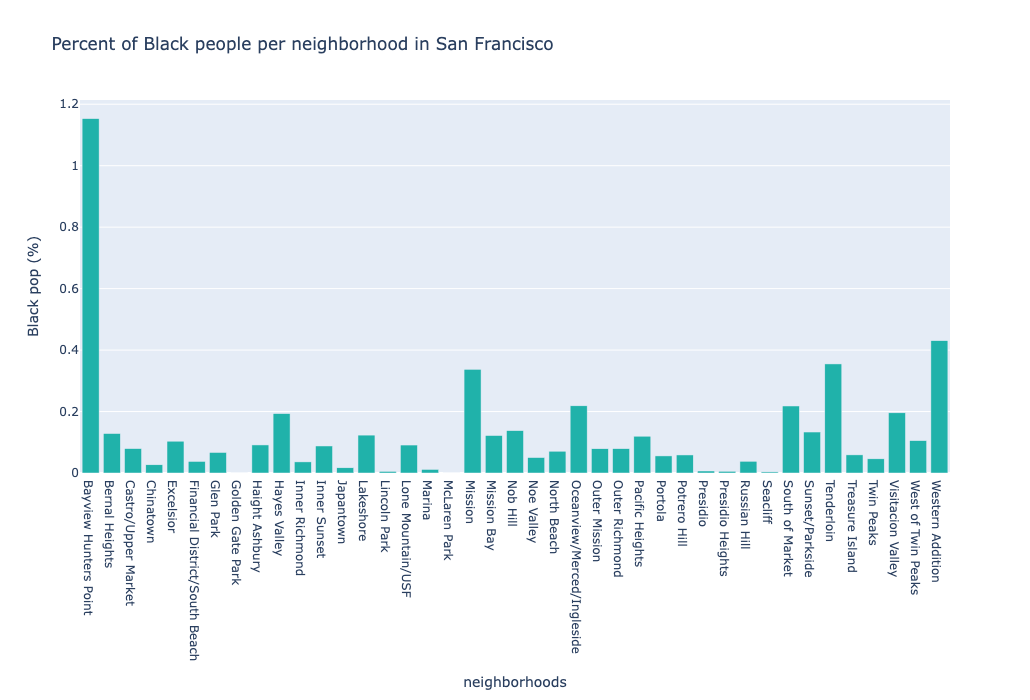

In [179]:
# test plot
blackpop_neighborhood = px.bar(race_neighborhood,
              x='neighborhoods',
              y='Black pop (%)',
              title='Percent of Black people per neighborhood in San Francisco',
              barmode='group',
              color_discrete_sequence=['lightseagreen'],
              height=700
              )
blackpop_neighborhood

In [180]:
race_percentage_columns = [col for col in race.columns if 'pop (%)' in col]

maps = {}

for col in race_percentage_columns:
    m = folium.Map(location=[37.7619, -122.4194], 
                   zoom_start=12,
                   tiles='CartoDB positron', 
                   attribution='CartoDB')

    folium.Choropleth(
        geo_data=race,
        data=race,         
        key_on='feature.properties.FIPS',
        columns=['FIPS', col],
        fill_color='YlGnBu',
        line_weight=0.1, 
        fill_opacity=0.8,
        line_opacity=0.5, 
        legend_name=f'{col} in San Francisco'
    ).add_to(m)

    style_function = lambda x: {'fillColor': '#ffffff', 
                                'color':'#000000', 
                                'fillOpacity': 0.1, 
                                'weight': 0.1}
    
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}

    TRACTS = folium.features.GeoJson(
        race,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['FIPS', 'neighborhoods', col],
            aliases=['FIPS Code: ', 'Neighborhood: ', f'{col}: '],
            style=("background-color: white; color: #333333; font-family: arial; "
                   "font-size: 12px; padding: 10px;")
        )
    )

    title_html = f'''
    <div style="position: absolute; top: 10px; left: 50%; transform: translate(-50%, 0);
                background-color: white; padding: 10px; font-size: 20px; font-weight: bold;
                z-index: 1000; border-radius: 5px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);">
         {col} in San Francisco
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    m.add_child(TRACTS)
    m.keep_in_front(TRACTS)
    folium.LayerControl().add_to(m)

    maps[col] = m  # Store the map in the dictionary

    # Save the map
    filename = f"map_{col.lower().replace(' ', '_')}.html"
    m.save(filename)
    print(f"Saved {filename}")

Saved map_black_pop_(%).html
Saved map_asian_pop_(%).html
Saved map_hispanic_latino_pop_(%).html
Saved map_white_pop_(%).html
